# II) Méthodes du projet

## Méthodes pour le nettoyage des données

In [1]:
# pour séparer les colonnes par type de donnée
def split_data_num_categ(df):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    
    dict_col = {
        'numeric': [],
        'category': [],
        'boolean': [],
        'datetime': [],
        'deltatime': []
    }
    
    for col in df.columns:
        if df[col].dtype.name in ('float64', 'int64'):
            dict_col['numeric'].append(col)
        elif df[col].dtype.name in ('object', 'category'):
            dict_col['category'].append(col)
        elif df[col].dtype.name == 'bool':
            dict_col['boolean'].append(col)
        elif df[col].dtype.name == 'datetime64':
            dict_col['datetime'].append(col)
        elif df[col].dtype.name == 'timedelta[ns]':
            dict_col['deltatime'].append(col)
        else:
            print("Type de données non connu :", df[col].dtype.name, "pour la colonne", col)

    print("Voici la répartition des colonnes par type de données :")
    for key, value in dict_col.items():
        nb_col_by_type = len(value)
        print(key, ":", nb_col_by_type, "colonnes.")
        if nb_col_by_type > 0:
            result.append(df[value])
    
    return result

In [2]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

## Méthode pour le LabelEncoding

In [3]:
from sklearn.preprocessing import LabelEncoder
def compute_encoding(df, df2=False):
    result = []
    
    # test sur dataset en input
    if len(df) == 0:
        print("Le DataFrame d'origine est vide.")
        return result
    df_copy = df.copy()
    
    is_second_df = False
    if df2 and len(df2) > 0:
        is_second_df = True
        df2_copy = df2.copy()
    
    nb_col_orig = len(df_copy.columns)
    print("Le DataFrame à encoder présente", len(df_copy), "lignes et", nb_col_orig, "colonnes.")
    nb_label = 0
    nb_one_hot = 0
    
    # Label Encoder
    label_encoder = LabelEncoder()
    for col in df_copy:
        if df_copy[col].dtype == 'object' and len(list(df_copy[col].unique())) <= 2:
            print("La colonne", col, "est label encodée")
            label_encoder.fit(df_copy[col])
            df_copy[col] = label_encoder.transform(df_copy[col])
            nb_label +=1
            # gestion 2 df (train et test)
            if is_second_df:
                df2_copy[col] = label_encoder.transform(df2_copy[col])
                
    # One-Hot Encoder
    nb_one_hot = len(df_copy.select_dtypes('object').apply(pd.Series.nunique, axis = 0))
    df_copy = pd.get_dummies(df_copy)
    if is_second_df:
        df2_copy = pd.get_dummies(df2_copy)
    
    print("Il y a eu", nb_label, "colonnes ayant eu le LabelEncoder.")
    print("Il y a eu", nb_one_hot, "colonnes ayant eu le One-Hot Encoder.")
    nb_col_actual = len(df_copy.columns)
    print("Une fois encodé, le DataFrame présente", len(df_copy), "lignes et", len(df_copy.columns), "colonnes.")
    time_plus_col = round(nb_col_actual/nb_col_orig, 1)
    print("Le Dataframe est maintenant", time_plus_col, "fois plus élevé.")
    return df_copy, df2_copy if is_second_df else df2

## Méthode pour impute and scale les dataset

In [4]:
#  imputer et scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
def impute_and_scale(train_set, test_set):
    # copie des 2 sets avant de les retourner modifiés
    train = train_set.copy()
    test = test_set.copy()

    # Imputer
    imputer = SimpleImputer(strategy = 'median')
    # Scaler
    scaler = MinMaxScaler(feature_range = (0, 1))

    # on fit l'imputer avec le trainning set uniquement
    imputer.fit(train)
    # on impute sur les 2 sets
    train = imputer.transform(train)
    test = imputer.transform(test)

    # on fait la même chose pour le scaler
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)

    return train, test

## Méthodes pour la Matrice de Confusion

In [5]:
from sklearn import metrics
def compute_confusion_matrix(y_true, y_pred, display_labels=None):
    # pour calculer la matrice de confusion
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    # pour afficher la matrice de confusion
    displ = metrics.ConfusionMatrixDisplay(cm, display_labels=display_labels)
    displ.plot()
    displ.ax_.xaxis.tick_top()
    displ.ax_.xaxis.set_label_position('top') 
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()

In [6]:
def display_classification_report(y_true, y_pred, display_labels=None):
    clf_report = metrics.classification_report(y_true, y_pred, target_names=display_labels)
    print(clf_report)
    # clf_report_dict = metrics.classification_report(y_true, y_pred, target_names=display_labels, output_dict=True)
    # df_clf_report = pd.DataFrame(clf_report_dict).round(2).T
    # return df_clf_report.head()

In [7]:
def plot_roc_curve(y_test, y_test_pred):  
    [fpr_te, tpr_te, thr_te] = metrics.roc_curve(y_test, y_test_pred)
    plt.plot(fpr_te, tpr_te, color='coral', lw=2, label="")
    
    # indice du premier seuil pour lequel
    # la sensibilité est supérieure à 0.95
#     idx = np.min(np.where(tpr_te > 0.95)) 

#     print("Sensibilité : {:.2f}".format(tpr_te[idx]))
#     print("Spécificité : {:.2f}".format(1-fpr_te[idx]))
#     print("Seuil : {:.2f}".format(thr_te[idx]))
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title("ROC")

In [8]:
def classification_metrics(model, X_test, y_test, y_test_pred, list_metrics=["accuracy"], all_metrics=False, roc_curve=False, beta=1):
    if all_metrics:
        list_metrics = ["accuracy", "recall", "precision", "auc", "f1", "fbeta"]
    for met in list_metrics:
        if met == "accuracy":
            te_res = metrics.accuracy_score(y_test, y_test_pred).round(3)
            print("Accuracy :", te_res)
        elif met == "precision":     
            te_res = metrics.precision_score(y_test, y_test_pred).round(3)
            print("Précision :", te_res)
        elif met == "recall":  
            te_res = metrics.recall_score(y_test, y_test_pred).round(3)
            print("Recall :", te_res)
        elif met == "auc":    
            te_res = metrics.roc_auc_score(y_test, y_test_pred).round(3)
            print("AUC :", te_res)
            if roc_curve:
                plot_roc_curve(y_test, y_test_pred)
        elif met == "f1":   
            te_res = metrics.f1_score(y_test, y_test_pred).round(3)
            print("F1-score :", te_res)
        elif met == "fbeta":
            te_res = metrics.fbeta_score(y_test, y_test_pred, beta=beta).round(3)
            print("Fbeta-score (beta=", beta,  ") :", te_res)

***
# III) Présentation générale du jeu de données

## 1) Exploration du dataset

### a) Imports

In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

### b) Chargement du dataset

In [10]:
raw_data = pd.read_csv('input/application_train.csv')

In [11]:
print("Le dataset brut présente", raw_data.shape[0], "lignes et", raw_data.shape[1], "colonnes")
raw_data.head()

Le dataset brut présente 307511 lignes et 122 colonnes


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


***
## 2) Traitement de réduction et de sélection des données

Le dataset présente énormément de colonnes et de lignes. Nous voulons le réduire pour faciliter son exploitation.  
Avant même de commencer à imputer des valeurs en traitant les valeurs manquantes et les outliers, nous allons effectuer différents filtrages de lignes et de colonnes.

### a) Suppression colonnes vides

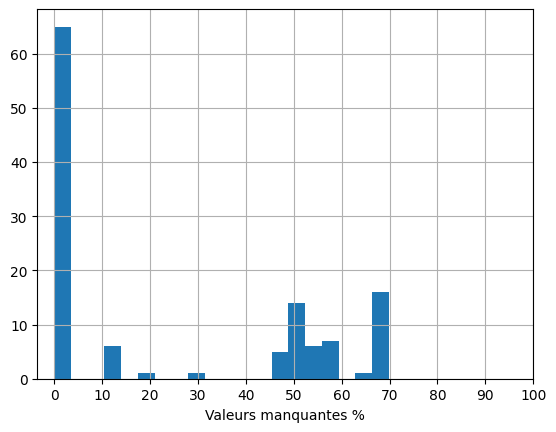

In [12]:
# on regarde la répartition des colonnes en fonction de la part de valeurs manquantes
valeurs_manquantes = round(raw_data.isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
missing_val_df["%"].hist(bins=20)
plt.xlabel("Valeurs manquantes %")
min_ylim, max_ylim = plt.ylim()
plt.xticks(np.arange(0, 101, 10))
plt.show()

On remarque qu'il n'y a pas de colonnes vides.

### b) Suppression lignes target vides

Ensuite nous avons choisi d'avoir une approche métier et technique de ce dataset. Nous avons une target totalement désignée `TARGET`. Sans cette donnée, nous ne pouvons pas entraîner nos modèles. Regardons si cette colonne est 100% renseignée.

In [13]:
# le nutriscore sera notre target, donc on peut supprimer toutes les lignes n'ayant pas de nutriscore renseigné
data_w_target = raw_data.loc[raw_data["TARGET"].notnull(), :]
print("Il y a", raw_data.shape[0] - data_w_target.shape[0], "lignes sans target de renseignée.")

Il y a 0 lignes sans target de renseignée.


<AxesSubplot: >

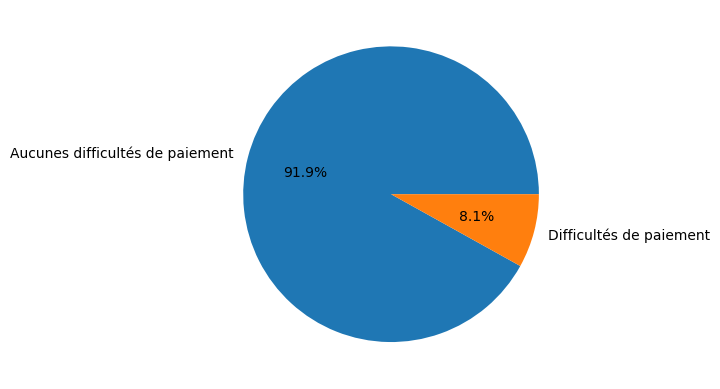

In [14]:
temp_val_count = raw_data['TARGET'].value_counts(normalize=True)
temp_val_count = temp_val_count.rename(index={1: 'Difficultés de paiement', 0: 'Aucunes difficultés de paiement'})
temp_val_count.plot(kind="pie", autopct=show_perc, labels=temp_val_count.index, label='')

On voit une répartition hétérogène de la target. Il faudra le prendre en compte durant l'étude de nos modèles.

### c) Séparation des colonnes par type de données

In [15]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(raw_data)

Voici la répartition des colonnes par type de données :
numeric : 106 colonnes.
category : 16 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


In [16]:
print("Le dataset est réparti comme suit :")
print("Colonnes de type numérique :", len(data_num.columns), "soit,", round(len(data_num.columns)/len(raw_data.columns)*100, 1), "% des colonnes du dataset brut.")
print("Colonnes de type catégoriel :", len(data_categ.columns), "soit,", round(len(data_categ.columns)/len(raw_data.columns)*100, 1), "% des colonnes du dataset brut.")

Le dataset est réparti comme suit :
Colonnes de type numérique : 106 soit, 86.9 % des colonnes du dataset brut.
Colonnes de type catégoriel : 16 soit, 13.1 % des colonnes du dataset brut.


### d) Sélection des variables catégorielles pertinentes

In [17]:
# regardons la liste des colonnes catégorielles
print(data_categ.columns)

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


En voyant cette liste, je vois plusieurs variables qui peuvent être supprimées :
 - `WEEKDAY_APPR_PROCESS_START` : le jour de la semaine où le client à contracté le prêt
 - `FLAG_OWN_CAR` : renseigne si le client a une voiture ou non

In [18]:
col_to_drop = ["WEEKDAY_APPR_PROCESS_START", "FLAG_OWN_CAR"]

### e) Sélection des variables numériques pertinentes

In [19]:
# regardons la liste des colonnes numériques
print(data_num.columns)

Index(['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=106)


Les colonnes commençant par `FLAG_` représente des valeurs pouvant être 0 ou 1. Regardons la liste.

In [20]:
col_w_flag = [x for x in data_num.columns if x.startswith("FLAG_")]
print(col_w_flag)

['FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']


On peut voir que ces variables indiquent si le client a un numéro de téléphone et s'il a fourni certains documents. Sans trop de risque, je considère que ces données ne seront pas utiles à nos modèles. Nous pouvons les supprimer.

In [21]:
col_to_drop = col_to_drop + col_w_flag

In [22]:
col_wo_flag = [x for x in data_num.columns if not x.startswith("FLAG_")]
print(col_wo_flag)

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_

En voyant cette liste, je vois plusieurs variables qui peuvent être supprimées :
 - `DAYS_LAST_PHONE_CHANGE` : nombre de jours depuis le dernier changement de téléphone du client
 - `HOUR_APPR_PROCESS_START` : heure à laquelle le client a contracté le prêt
 - `OWN_CAR_AGE` : à quel âge le client a obtenu sa voiture

In [23]:
col_to_drop = col_to_drop + ["DAYS_LAST_PHONE_CHANGE", "HOUR_APPR_PROCESS_START", "OWN_CAR_AGE"]

In [24]:
data_drop_col = raw_data.drop(col_to_drop, axis=1)
print("Suppression de", len(col_to_drop), "colonnes non pertinentes soit,", round(len(col_to_drop)/len(raw_data.columns)*100, 1), "% des colonnes.")

Suppression de 31 colonnes non pertinentes soit, 25.4 % des colonnes.


In [25]:
print("Après la suppression des colonnes non pertinentes, le dataset présente", data_drop_col.shape[0], "lignes et", data_drop_col.shape[1], "colonnes")

Après la suppression des colonnes non pertinentes, le dataset présente 307511 lignes et 91 colonnes


### f) Sélection des variables numériques par corrélation

***
Afin de réduire d'avantage le nombre de colonne, regardons les corrélations fortes entre variables.

In [26]:
data_num, data_categ = split_data_num_categ(data_drop_col)

Voici la répartition des colonnes par type de données :
numeric : 77 colonnes.
category : 14 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


In [27]:
# extraire les variables étant très corrélées > 0.8
list_col_num = data_num.columns
corr = data_drop_col[list_col_num].corr().values
nb_col = len(list_col_num)
nb_correl = 0
list_col_stat_correl = []
for i in range(nb_col):
    for j in range(i+1, nb_col):
        if abs(corr[i,j]) >= 0.8:
            # print(list_col_num[i], ' ', list_col_num[j], ' ', corr[i,j])
            nb_correl += 1
            if list_col_num[i].endswith(('_AVG', '_MODE', '_MEDI')):
                list_col_stat_correl.append(list_col_num[i])
            if list_col_num[j].endswith(('_AVG', '_MODE', '_MEDI')):
                list_col_stat_correl.append(list_col_num[j])
                
list_col_stat_correl = list(set(list_col_stat_correl))
print("Il y a", nb_correl, "paires de corrélation.")
print("Il y a", len(list_col_stat_correl), "colonnes de stats.")

Il y a 111 paires de corrélation.
Il y a 43 colonnes de stats.


On observe une tendance avec des colonnes représentants des statistiques. On les reconnait car finissent par _AVG, _MODE et _MEDI. Commençons par traiter ces variables pour y voir plus claire dans celles qui restent.

In [28]:
# faisons la liste des préfixes avec la liste de leur suffixe concernant les variables statistiques
list_col_stat_correl.sort()
dict_col_stat = {}
for col in list_col_stat_correl:
    temp_col = col.split('_')
    if len(temp_col) == 2:
        temp_key = temp_col[0]
    elif len(temp_col) == 3:
        temp_key = temp_col[0] + "_" + temp_col[1]
    else:
        break
    if temp_key in dict_col_stat:
        dict_col_stat[temp_key].append(temp_col[-1])
    else:
        dict_col_stat[temp_key] = [temp_col[-1]]

In [29]:
# dans un dataframe pour que ce soit plus lisible
data_col_stat = pd.DataFrame.from_dict(dict_col_stat, orient="index")
data_col_stat

,0,1,2
APARTMENTS,AVG,MEDI,MODE
BASEMENTAREA,AVG,MEDI,MODE
COMMONAREA,AVG,MEDI,MODE
ELEVATORS,AVG,MEDI,MODE
ENTRANCES,AVG,MEDI,MODE
FLOORSMAX,AVG,MEDI,MODE
FLOORSMIN,AVG,MEDI,MODE
LANDAREA,AVG,MEDI,MODE
LIVINGAPARTMENTS,AVG,MEDI,MODE
LIVINGAREA,AVG,MEDI,MODE


Pour presque toutes ces variables, nous avons les 3 statistiques. Nous allons garder la médiane (_MEDI) et supprimer les 2 autres. En revanche, pour TOTALAREA, on ne fait rien.

In [30]:
# pour faire la liste des variables avec les 2 suffixe que l'on souhaite
col_corr_to_drop = [["{}_AVG".format(key), "{}_MODE".format(key)] for key, value in dict_col_stat.items() if len(value) == 3]
# pour flatten la liste
col_corr_to_drop = [item for sublist in col_corr_to_drop for item in sublist]
print("On va supprimer", len(col_corr_to_drop), "colonnes de statistiques correllées.")

On va supprimer 28 colonnes de statistiques correllées.


Regardons maintenant les variables correllées restantes.

In [31]:
# extraire les variables étant très corrélées > 0.8
list_col_num = [x for x in data_num.columns if x not in col_corr_to_drop]
corr = data_drop_col[list_col_num].corr().values
nb_col = len(list_col_num)
nb_correl = 0
list_col_stat_correl = []
for i in range(nb_col):
    for j in range(i+1, nb_col):
        if abs(corr[i,j]) >= 0.8:
            print(list_col_num[i], ' ', list_col_num[j], ' ', corr[i,j])
            nb_correl += 1
            if list_col_num[i].endswith(('_AVG', '_MODE', '_MEDI')):
                list_col_stat_correl.append(list_col_num[i])
            if list_col_num[j].endswith(('_AVG', '_MODE', '_MEDI')):
                list_col_stat_correl.append(list_col_num[j])
                
list_col_stat_correl = list(set(list_col_stat_correl))
print("Il y a", nb_correl, "paires de corrélation.")
print("Il y a", len(list_col_stat_correl), "colonnes de stats.")

CNT_CHILDREN   CNT_FAM_MEMBERS   0.879160640438957
AMT_CREDIT   AMT_GOODS_PRICE   0.9869683054221499
REGION_RATING_CLIENT   REGION_RATING_CLIENT_W_CITY   0.9508422141646482
REG_REGION_NOT_WORK_REGION   LIVE_REGION_NOT_WORK_REGION   0.8606267802832626
REG_CITY_NOT_WORK_CITY   LIVE_CITY_NOT_WORK_CITY   0.8255747229688812
APARTMENTS_MEDI   ELEVATORS_MEDI   0.8374473132894182
APARTMENTS_MEDI   LIVINGAPARTMENTS_MEDI   0.9424851483864675
APARTMENTS_MEDI   LIVINGAREA_MEDI   0.9159473447265859
APARTMENTS_MEDI   TOTALAREA_MODE   0.8865682509734882
ELEVATORS_MEDI   LIVINGAPARTMENTS_MEDI   0.8142183219635333
ELEVATORS_MEDI   LIVINGAREA_MEDI   0.8683406875915228
ELEVATORS_MEDI   TOTALAREA_MODE   0.8380276070011439
LIVINGAPARTMENTS_MEDI   LIVINGAREA_MEDI   0.8846900455382541
LIVINGAPARTMENTS_MEDI   TOTALAREA_MODE   0.8461050011686108
LIVINGAREA_MEDI   TOTALAREA_MODE   0.9193633193815423
OBS_30_CNT_SOCIAL_CIRCLE   OBS_60_CNT_SOCIAL_CIRCLE   0.998489542510996
DEF_30_CNT_SOCIAL_CIRCLE   DEF_60_CNT_SOC

On peut maintenant faire un choix à la main.  
**Garder** AMT_CREDIT, REGION_RATING_CLIENT, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, LIVINGAREA_MEDI, CNT_CHILDREN, REG_REGION_NOT_WORK_REGION, REG_CITY_NOT_WORK_CITY  
**Supprimer** AMT_GOODS_PRICE, REGION_RATING_CLIENT_W_CITY, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, APARTMENTS_MEDI, LIVINGAPARTMENTS_MEDI, TOTALAREA_MODE, CNT_FAM_MEMBERS, LIVE_REGION_NOT_WORK_REGION, LIVE_CITY_NOT_WORK_CITY, ELEVATORS_MEDI

In [32]:
col_corr_to_drop = col_corr_to_drop + [
    "AMT_GOODS_PRICE", "REGION_RATING_CLIENT_W_CITY", "OBS_60_CNT_SOCIAL_CIRCLE", "DEF_60_CNT_SOCIAL_CIRCLE", "APARTMENTS_MEDI", "LIVINGAPARTMENTS_MEDI",
    "TOTALAREA_MODE", "CNT_FAM_MEMBERS", "LIVE_REGION_NOT_WORK_REGION", "LIVE_CITY_NOT_WORK_CITY", "ELEVATORS_MEDI"
]
data_drop_col_corr = data_drop_col.drop(col_corr_to_drop, axis=1)
print("Un total de", len(col_corr_to_drop), "colonnes numériques fortement correllées ont été suprimées, soit,", round(len(col_corr_to_drop)/len(data_drop_col.columns)*100, 1), "% des colonnes.")

Un total de 39 colonnes numériques fortement correllées ont été suprimées, soit, 42.9 % des colonnes.


In [33]:
print("Après la suppression des colonnes fortements corrélées, le dataset présente", data_drop_col_corr.shape[0], "lignes et", data_drop_col_corr.shape[1], "colonnes")

Après la suppression des colonnes fortements corrélées, le dataset présente 307511 lignes et 52 colonnes


In [34]:
data_num, data_categ = split_data_num_categ(data_drop_col_corr)

Voici la répartition des colonnes par type de données :
numeric : 38 colonnes.
category : 14 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


***
## 3) Traitement de nettoyage des données

### a) Traitements des valeurs manquantes

Commençons par les variables catégorielles.

In [35]:
# on regarde la répartition des colonnes en fonction de la part de valeurs manquantes
valeurs_manquantes = round(data_drop_col_corr[data_categ.columns].isnull().mean()*100, 4).sort_values(ascending=False)
missing_val_df = pd.DataFrame(valeurs_manquantes, columns = ["%"])
col_w_miss_val = missing_val_df.loc[missing_val_df["%"] > 0, :]
col_w_miss_val.head(10)

,%
FONDKAPREMONT_MODE,68.3862
WALLSMATERIAL_MODE,50.8408
HOUSETYPE_MODE,50.1761
EMERGENCYSTATE_MODE,47.3983
OCCUPATION_TYPE,31.3455
NAME_TYPE_SUITE,0.4201


In [36]:
nb_miss_categ = data_drop_col_corr[data_categ.columns].isnull().sum().sum()
nb_tot_data = data_drop_col_corr.shape[0] * len(data_drop_col_corr.columns)
print("Pour les variables catégorielles, il manque", nb_miss_categ , "entrées, soit", round(nb_miss_categ/nb_tot_data*100, 2), "% des données totales.")

Pour les variables catégorielles, il manque 764371 entrées, soit 4.78 % des données totales.


Pour chacune de ces variables, plusieurs constats : 
 - je ne suis pas capable de savoir si elles seront pertinentes ou non pour notre étude
 - je ne peux remplacer les valeurs manquantes par une statistique quelconque (médiane, moyenne ou mode) car cela déséquilibrerait les données

Je choisis donc de remplacer les valeurs manquantes par la valeur "other".

In [37]:
for col in col_w_miss_val.index:
    data_drop_col_corr[col].fillna("Other", inplace=True)

***
Regardons maintenant les variables de type numérique.

In [38]:
# voici la répartition des données manquantes pour les données numériques
miss_num = round(data_drop_col_corr[data_num.columns].isnull().mean()*100, 4).sort_values(ascending=False)
miss_num_df = pd.DataFrame(miss_num, columns = ["%"])
miss_num_df.head(24)

,%
COMMONAREA_MEDI,69.8723
NONLIVINGAPARTMENTS_MEDI,69.4330
FLOORSMIN_MEDI,67.8486
YEARS_BUILD_MEDI,66.4978
LANDAREA_MEDI,59.3767
BASEMENTAREA_MEDI,58.5160
EXT_SOURCE_1,56.3811
NONLIVINGAREA_MEDI,55.1792
ENTRANCES_MEDI,50.3488
LIVINGAREA_MEDI,50.1933


Pour les mêmes raisons que pour les variables de type catégoriel, je ne vais pas pouvoir remplir les valeurs manquantes de manière pertinente.

In [39]:
nb_miss_num = data_drop_col_corr[data_num.columns].isnull().sum().sum()
print("Pour les variables numériques, il manque", nb_miss_num , "entrées, soit", round(nb_miss_num/nb_tot_data*100, 2), "% des données totales.")

Pour les variables numériques, il manque 2472100 entrées, soit 15.46 % des données totales.


NB : je ne remplis pas tout de suite les valeurs numériques manquantes car dans le cadrede l'étude de nos modèles, je dois d'abord splitter le dataset. Ensuite seulement, je pourrai renseigner les valeurs manquantes.

### b) Traitements des outliers

Passon maintenant au traitement des outliers.

In [40]:
data_drop_col_corr.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,1.000020e+05,189145.500000,278202.000000,367142.500000,4.562550e+05
TARGET,307511.0,0.080729,0.272419,0.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
CNT_CHILDREN,307511.0,0.417052,0.722121,0.000000e+00,0.000000,0.000000,1.000000,1.900000e+01
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,2.565000e+04,112500.000000,147150.000000,202500.000000,1.170000e+08
AMT_CREDIT,307511.0,599025.999706,402490.776996,4.500000e+04,270000.000000,513531.000000,808650.000000,4.050000e+06
AMT_ANNUITY,307499.0,27108.573909,14493.737315,1.615500e+03,16524.000000,24903.000000,34596.000000,2.580255e+05
REGION_POPULATION_RELATIVE,307511.0,0.020868,0.013831,2.900000e-04,0.010006,0.018850,0.028663,7.250800e-02
DAYS_BIRTH,307511.0,-16036.995067,4363.988632,-2.522900e+04,-19682.000000,-15750.000000,-12413.000000,-7.489000e+03
DAYS_EMPLOYED,307511.0,63815.045904,141275.766519,-1.791200e+04,-2760.000000,-1213.000000,-289.000000,3.652430e+05
DAYS_REGISTRATION,307511.0,-4986.120328,3522.886321,-2.467200e+04,-7479.500000,-4504.000000,-2010.000000,0.000000e+00


Tout semble en ordre pour la plupart des colonnes. Nous allons cependant nous pencher sur les variables commençant par DAYS_. Nous allons les convertir en année pour mieux nous rendre compte si tout va bien. A noter que les valeurs sont en négatif.

In [41]:
# traitement sur les variables commençant par DAYS_
col_days = [x for x in data_num.columns if x.startswith("DAYS_")]
for col in col_days:
    temp_col = col.removeprefix('DAYS_')
    temp_col = "Y_{}".format(temp_col)
    data_drop_col_corr[temp_col] = abs(data_drop_col_corr[col] / 365.25)
col_days_y = [x for x in data_drop_col_corr.columns if (x.startswith("DAYS_") | x.startswith("Y_"))]
data_drop_col_corr[col_days_y].describe()

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,Y_BIRTH,Y_EMPLOYED,Y_REGISTRATION,Y_ID_PUBLISH
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,-16036.995067,63815.045904,-4986.120328,-2994.202373,43.906900,185.420239,13.651253,8.197679
std,4363.988632,141275.766519,3522.886321,1509.450419,11.947950,381.776186,9.645137,4.132650
min,-25229.000000,-17912.000000,-24672.000000,-7197.000000,20.503765,0.000000,0.000000,0.000000
25%,-19682.000000,-2760.000000,-7479.500000,-4299.000000,33.984942,2.554415,5.503080,4.709103
50%,-15750.000000,-1213.000000,-4504.000000,-3254.000000,43.121150,6.075291,12.331280,8.908966
75%,-12413.000000,-289.000000,-2010.000000,-1720.000000,53.886379,15.624914,20.477755,11.770021
max,-7489.000000,365243.000000,0.000000,0.000000,69.073238,999.980835,67.548255,19.704312


On ne repère qu'une seule anomalie. Pour les années d'emploi, on observe des valeurs à 1000. Ces valeurs sont probablement les personnes sans emploi. On cale plutôt la valeur à NaN. Mais on garde l'info dans une nouvelle colonne.

In [42]:
# flag sans emploi
data_drop_col_corr.loc[data_drop_col_corr["Y_EMPLOYED"] > 999, 'FLAG_UNEMPLOYED'] = 'Y'
data_drop_col_corr.loc[data_drop_col_corr["Y_EMPLOYED"] < 999, 'FLAG_UNEMPLOYED'] = 'N'

# remplace valeur abérrantes par 0
data_drop_col_corr.loc[data_drop_col_corr['FLAG_UNEMPLOYED'] == 'Y', 'DAYS_EMPLOYED'] = 0
data_drop_col_corr.loc[data_drop_col_corr['FLAG_UNEMPLOYED'] == 'Y', 'Y_EMPLOYED'] = 0

In [43]:
nb_unemployed = len(data_drop_col_corr.loc[data_drop_col_corr['FLAG_UNEMPLOYED'] == 'Y', :])
print("Il y a", nb_unemployed, "prêts attribués à des personnes sans emploi soit,", round(nb_unemployed/data_drop_col_corr.shape[0]*100, 1), "% des données.")

Il y a 55374 prêts attribués à des personnes sans emploi soit, 18.0 % des données.


In [44]:
# suppression des colonnes commençant par DAYS_
data_drop_col_days = data_drop_col_corr.drop(col_days, axis=1)

### c) Suppression lignes dupliquées

Regardons s'il y a des lignes dupliquées.

In [45]:
# identification et suppressions des lignes dupliquées
nb_lignes_dupli = data_drop_col_days.duplicated().sum()
print("Il y a", nb_lignes_dupli, "lignes dupliquées dans ce dataset.")

Il y a 0 lignes dupliquées dans ce dataset.


***
# IV Compréhension du dataset

## 1) Shape du dataset d'étude

In [46]:
# Bilan sur le dataset d'étude
data_study = data_drop_col_days
print("Notre dataset d'étude présente", data_study.shape[0], "lignes et", data_study.shape[1], "colonnes")
print("Par rapport à notre dataset brut, on a gardé", round(data_study.shape[0]/raw_data.shape[0]*100, 2), "% de lignes et", round(data_study.shape[1]/raw_data.shape[1]*100, 2), "% de colonnes.")
print("Par rapport à notre dataset brut, on a supprimé", round((1-data_study.shape[0]/raw_data.shape[0])*100, 2), "% de lignes et", round((1-data_study.shape[1]/raw_data.shape[1])*100, 2), "% de colonnes.")

Notre dataset d'étude présente 307511 lignes et 53 colonnes
Par rapport à notre dataset brut, on a gardé 100.0 % de lignes et 43.44 % de colonnes.
Par rapport à notre dataset brut, on a supprimé 0.0 % de lignes et 56.56 % de colonnes.


In [47]:
# On regarde la répartition des colonnes en fonction de leur type
data_num, data_categ = split_data_num_categ(data_study)

Voici la répartition des colonnes par type de données :
numeric : 38 colonnes.
category : 15 colonnes.
boolean : 0 colonnes.
datetime : 0 colonnes.
deltatime : 0 colonnes.


## 2) Analyse univariée

Regardons la répartition de différentes variables notables dans notre dataset. Voici la liste :
 - `AMT_CREDIT` : montant du crédit emprunté
 - `Y_BIRTH` : âge du client au moment de contracter l'emprunt
 - `Y_EMPLOYED` : ancienneté du client à son travail
 - `CODE_GENDER` : le client est un homme ou une femme
 - `NAME_FAMILY_STATUS` : status marital du client

### a) Variables numériques

Moyenne :  599026.0


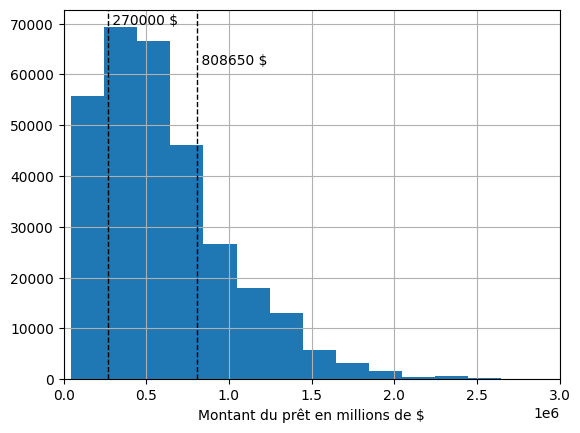

In [48]:
# Montant du prêt
print("Moyenne : ", round(data_study["AMT_CREDIT"].mean(), 0))
quartiles = [np.percentile(data_study["AMT_CREDIT"], p) for p in [25, 75]]
data_study["AMT_CREDIT"].hist(bins=20)
plt.xlabel("Montant du prêt en millions de $")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.96, ' {:.0f} $'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} $'.format(quartiles[1]))
plt.xlim((0, 3000000))
plt.show()

In [49]:
# Montant prêt > 1 million
nb_sup_million = data_study.loc[data_study["AMT_CREDIT"] >= 1000000, :]
print("Les clients ayant un prêt d'un montant supérieur à 1 million de dollars représentent", round(len(nb_sup_million)/len(data_study)*100, 1), "% du total.")

Les clients ayant un prêt d'un montant supérieur à 1 million de dollars représentent 16.3 % du total.


Moyenne :  44.0


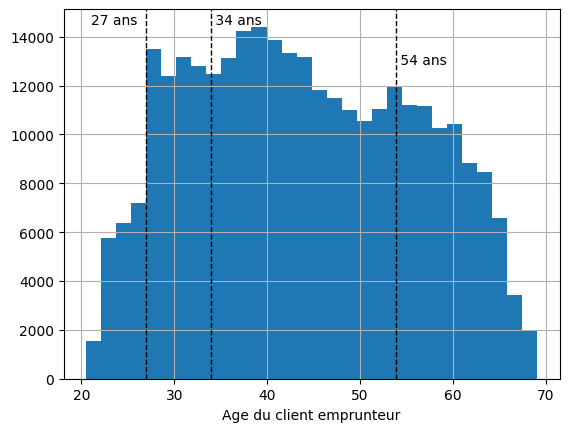

In [50]:
# Age du client
print("Moyenne : ", round(data_study["Y_BIRTH"].mean(), 0))
quartiles = [np.percentile(data_study["Y_BIRTH"], p) for p in [25, 75]]
data_study["Y_BIRTH"].hist(bins=30)
plt.xlabel("Age du client emprunteur")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.axvline(27, color='k', linestyle='dashed', linewidth=1)
plt.text(21, max_ylim*0.96, '27 ans')
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.96, ' {:.0f} ans'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} ans'.format(quartiles[1]))
plt.show()

In [51]:
# < à 27? et > 60ans
# Age du client < 27 ans
nb_inf_age = data_study.loc[data_study["Y_BIRTH"] <= 27, :]
print("Les clients âgés de moins de 27 ans représentent", round(len(nb_inf_age)/len(data_study)*100, 1), "% du total.")

# Age du client > 60 ans
nb_sup_age = data_study.loc[data_study["Y_BIRTH"] >= 60, :]
print("Les clients âgés de plus de 60 ans représentent", round(len(nb_sup_age)/len(data_study)*100, 1), "% du total.")

Les clients âgés de moins de 27 ans représentent 6.8 % du total.
Les clients âgés de plus de 60 ans représentent 11.5 % du total.


Moyenne :  5.0


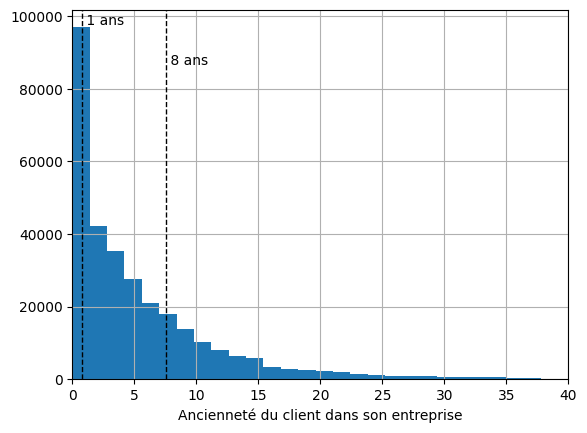

In [52]:
# Ancienneté du client dans son entreprise
print("Moyenne : ", round(data_study["Y_EMPLOYED"].mean(), 0))
quartiles = [np.percentile(data_study["Y_EMPLOYED"], p) for p in [25, 75]]
data_study["Y_EMPLOYED"].hist(bins=35)
plt.xlabel("Ancienneté du client dans son entreprise")
# pour tracer les 1er et 3ème quartiles
min_ylim, max_ylim = plt.ylim()
plt.axvline(quartiles[0], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[0], max_ylim*0.96, ' {:.0f} ans'.format(quartiles[0]))
plt.axvline(quartiles[1], color='k', linestyle='dashed', linewidth=1)
plt.text(quartiles[1], max_ylim*0.85, ' {:.0f} ans'.format(quartiles[1]))
plt.xlim((0, 40))
plt.show()

In [53]:
# Ancienneté au travail > 10 ans
nb_sup_empl = data_study.loc[data_study["Y_EMPLOYED"] >= 10, :]
print("Les clients ayant une ancienneté en entreprise de plus de 10 ans représentent", round(len(nb_sup_empl)/len(data_study)*100, 1), "% du total.")

Les clients ayant une ancienneté en entreprise de plus de 10 ans représentent 16.6 % du total.


### b) Variables catégorielles

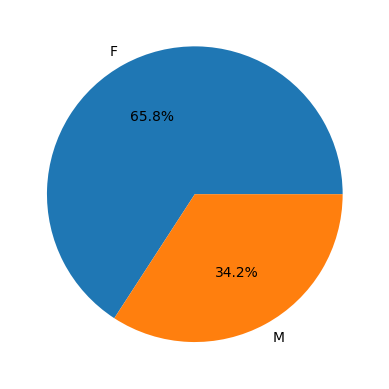

In [54]:
# Répartition du genre chez le client
temp_val_count = data_study["CODE_GENDER"].value_counts(normalize=True)
temp_val_count.plot(kind="pie", autopct=show_perc, labels=show_labels(temp_val_count), label='')
plt.show()

On remarque que le genre du client est hétérogène. Les 2/3 sont des femmes.

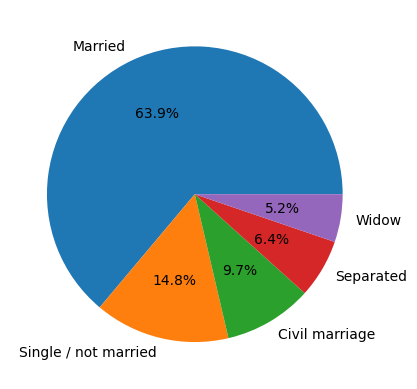

In [55]:
# Répartition du status marital chez le client
temp_val_count = data_study["NAME_FAMILY_STATUS"].value_counts(normalize=True)
temp_val_count.plot(kind="pie", autopct=show_perc, labels=show_labels(temp_val_count), label='')
plt.show()

Plus de 60% des clients sont marriés.

## 3) LabelEncoding

Maintenant que nous avons une meilleure compréhension du dataset, nous pouvons traiter les variables catégorielles pour l'étude des modèles.

In [56]:
# Liste des variables catégorielles avec leur nombre de valeurs unique
data_categ.apply(pd.Series.nunique, axis = 0).sort_values(ascending=False)

ORGANIZATION_TYPE      58
OCCUPATION_TYPE        19
NAME_TYPE_SUITE         8
NAME_INCOME_TYPE        8
WALLSMATERIAL_MODE      8
NAME_FAMILY_STATUS      6
NAME_HOUSING_TYPE       6
NAME_EDUCATION_TYPE     5
FONDKAPREMONT_MODE      5
HOUSETYPE_MODE          4
CODE_GENDER             3
EMERGENCYSTATE_MODE     3
NAME_CONTRACT_TYPE      2
FLAG_OWN_REALTY         2
FLAG_UNEMPLOYED         2
dtype: int64

Pour les variables ayant 2 valeurs uniques, on fera un Label Encoding qui remplacera les valeurs par 1 ou 0 arbitrairement.  
Pour les variables ayant plus de 2 valeurs uniques, on utilisera le One-Hot Encoding qui créera autant de colonne que de valeur unique possible.

In [58]:
data_encode, data_encode2 = compute_encoding(data_study)

Le DataFrame à encoder présente 307507 lignes et 53 colonnes.
La colonne NAME_CONTRACT_TYPE est label encodée
La colonne CODE_GENDER est label encodée
La colonne FLAG_OWN_REALTY est label encodée
La colonne FLAG_UNEMPLOYED est label encodée
Il y a eu 4 colonnes ayant eu le LabelEncoder.
Il y a eu 11 colonnes ayant eu le One-Hot Encoder.
Une fois encodé, le DataFrame présente 307507 lignes et 172 colonnes.
Le Dataframe est maintenant 3.2 fois plus élevé.


***
# V) Analyse de la problématique

## 1) Corrélations entre la Target et les autres variables

Regardons les corrélations entre la target et les autres variables

In [59]:
# correlations entre la target et les autres variables
correlations = data_encode.corr()['TARGET'].sort_values(ascending=False)

In [60]:
print('Most Positive Correlations:\n', correlations.tail(10))
print('\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 FLAG_UNEMPLOYED                        -0.045989
ORGANIZATION_TYPE_XNA                  -0.045989
Y_EMPLOYED                             -0.046050
NAME_INCOME_TYPE_Pensioner             -0.046211
Y_ID_PUBLISH                           -0.051457
NAME_EDUCATION_TYPE_Higher education   -0.056593
Y_BIRTH                                -0.078242
EXT_SOURCE_1                           -0.155317
EXT_SOURCE_2                           -0.160471
EXT_SOURCE_3                           -0.178926
Name: TARGET, dtype: float64

Most Negative Correlations:
 TARGET                                               1.000000
REGION_RATING_CLIENT                                 0.058901
NAME_INCOME_TYPE_Working                             0.057483
CODE_GENDER                                          0.054710
REG_CITY_NOT_WORK_CITY                               0.050992
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049822
REG_CITY_NOT_LIVE_CITY                            

Classons les par ordre d'importance, peu importe leur signe.

In [61]:
correlations_abs = pd.DataFrame(correlations)
correlations_abs["TAR_ABS"] = abs(correlations_abs["TARGET"])
correlations_abs.sort_values("TAR_ABS", ascending=False).head(17)

,TARGET,TAR_ABS
TARGET,1.000000,1.000000
EXT_SOURCE_3,-0.178926,0.178926
EXT_SOURCE_2,-0.160471,0.160471
EXT_SOURCE_1,-0.155317,0.155317
Y_BIRTH,-0.078242,0.078242
REGION_RATING_CLIENT,0.058901,0.058901
NAME_INCOME_TYPE_Working,0.057483,0.057483
NAME_EDUCATION_TYPE_Higher education,-0.056593,0.056593
CODE_GENDER,0.054710,0.054710
Y_ID_PUBLISH,-0.051457,0.051457


Les corrélations ne sont pas fortes, mais nous voyons des tendances avec les variables suivantes classées par ordre d'importance : 
 - `EXT_SOURCE_1`, `EXT_SOURCE_2` et `EXT_SOURCE_3` : données venant de sources extérieures
 - `Y_BIRTH` : âge du client au moment de la souscription
 - `REGION_RATING_CLIENT` : note donnée par HomeCredit pour la région où vit le client
 - `NAME_INCOME_TYPE_Working` : si les revenus du client proviennent de son travail
 - `NAME_EDUCATION_TYPE_Higher education` : si le client a un niveau d'étude supérieur
 - `CODE_GENDER` : le genre du client
 - `Y_ID_PUBLISH` : le nombre de jours depuis lequel le client a changé sa carte d'identité
 - `REG_CITY_NOT_WORK_CITY` : si le client a une adresse permanente correspondante à l'adresse de son travail ou pas
 - `NAME_EDUCATION_TYPE_Secondary / secondary special` : si le client a un niveau d'étude secondaire
 - `NAME_INCOME_TYPE_Pensioner` : si les revenus du client proviennent d'une pension
 - `Y_EMPLOYED` et `FLAG_UNEMPLOYED` : l'ancienneté du client à son travail et donc s'il travaille
 - `ORGANIZATION_TYPE_XNA` : si le client travaille dans une organisation de type non défini

Cependant, nous allons regarder de plus près les variables `EXT_SOURCE_1`,`EXT_SOURCE_2`, `EXT_SOURCE_3`, `Y_BIRTH`, `Y_ID_PUBLISH` et `Y_EMPLOYED` qui après étude, montrent des tendances intéressantes.

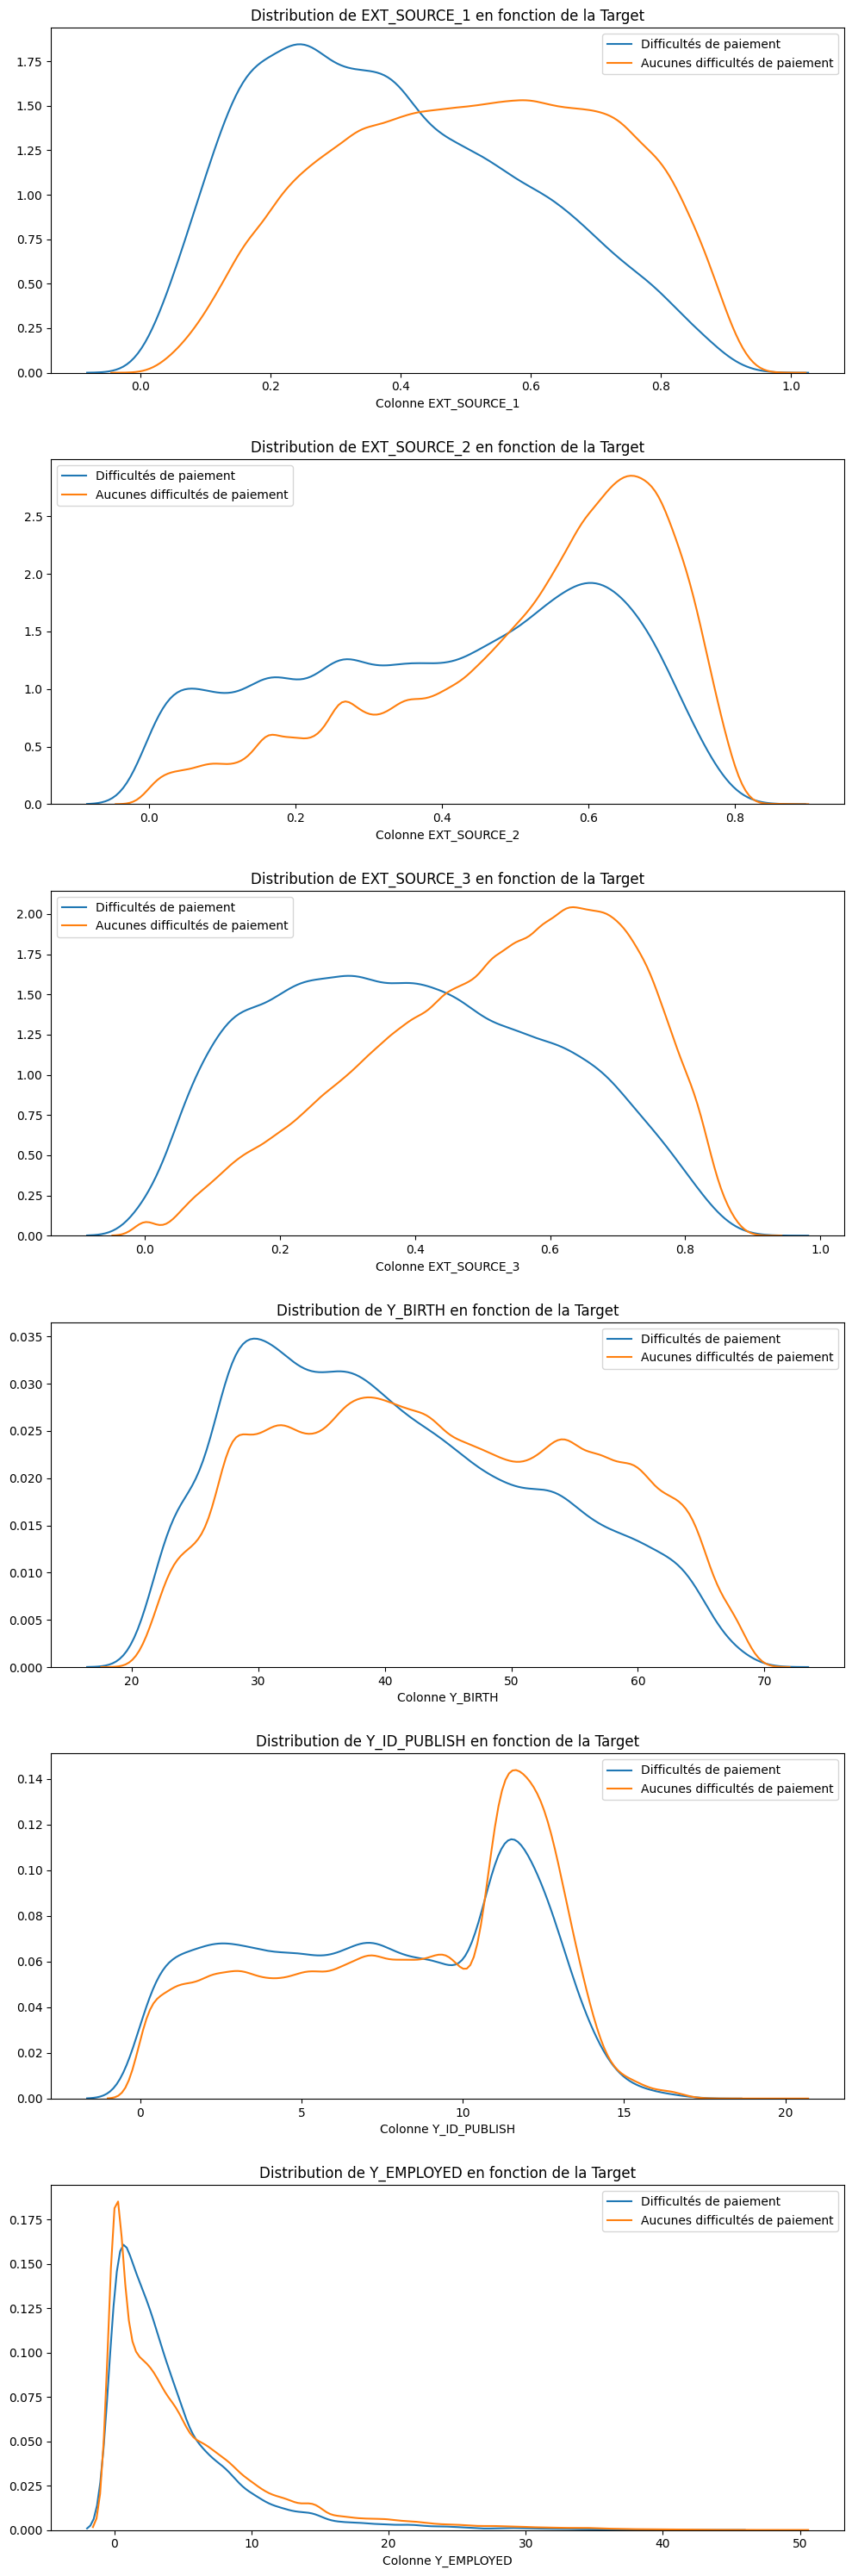

In [62]:
plt.figure(figsize = (10, 30))
# plt.style.use('fivethirtyeight')
col_to_explore = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'Y_BIRTH', 'Y_ID_PUBLISH', 'Y_EMPLOYED']

for i, source in enumerate(col_to_explore):
    
    # creer un graphique pour chaque variable
    plt.subplot(len(col_to_explore), 1, i + 1)
    
    # tracer les 2 lignes pour distinguer la valeur de la target
    sns.kdeplot(data_encode.loc[data_encode['TARGET'] == 1, source], label = 'Difficultés de paiement')
    sns.kdeplot(data_encode.loc[data_encode['TARGET'] == 0, source], label = 'Aucunes difficultés de paiement')
    
    # Titres et axes des graphiques
    plt.title('Distribution de %s en fonction de la Target' % source)
    plt.xlabel('Colonne %s' % source)
    plt.ylabel('')
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

## 2) Classification linéaire

In [63]:
# split des données
data = data_encode
target_labels = ["payment on time", "payment difficulties"]
X = data.loc[:, data.columns != "TARGET"]
y = data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # stratify pour avoir meme répartition de target

In [64]:
#  imputer et scaler
X_train_std, X_test_std = impute_and_scale(X_train, X_test)

In [65]:
from imblearn.over_sampling import SMOTE
from collections import Counter
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train_std, y_train)
print('Original dataset shape', Counter(y_train))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 197877, 1: 17377})
Resample dataset shape Counter({0: 197877, 1: 197877})


In [66]:
list_metrics=["accuracy", "recall", "auc", "f1", "fbeta"]

### a) DummyClassifier

In [67]:
from sklearn import dummy
dummyModel = dummy.DummyClassifier(strategy="stratified")
dummyModel.fit(X_train_std, y_train)

DummyClassifier(strategy='stratified')

In [68]:
y_pred_dummy = dummyModel.predict(X_test_std)

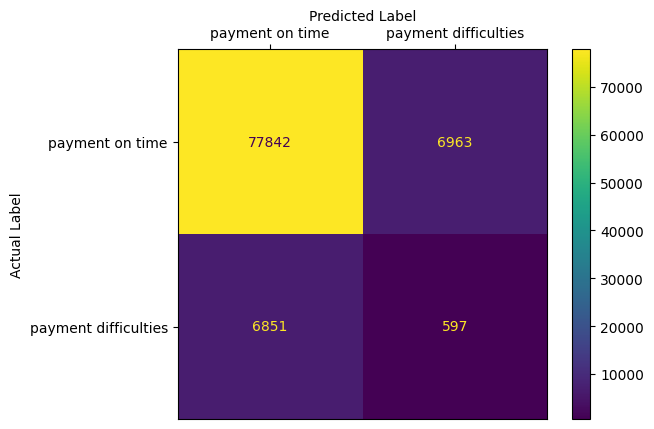

In [69]:
compute_confusion_matrix(y_test, y_pred_dummy, display_labels=target_labels)

In [70]:
display_classification_report(y_test, y_pred_dummy, display_labels=target_labels)

                      precision    recall  f1-score   support

     payment on time       0.92      0.92      0.92     84805
payment difficulties       0.08      0.08      0.08      7448

            accuracy                           0.85     92253
           macro avg       0.50      0.50      0.50     92253
        weighted avg       0.85      0.85      0.85     92253



In [71]:
classification_metrics(dummyModel, X_test, y_test, y_pred_dummy, list_metrics=list_metrics, roc_curve=False, beta=2)

Accuracy : 0.85
Recall : 0.08
AUC : 0.499
F1-score : 0.08
Fbeta-score (beta= 2 ) : 0.08


### b) Logistic Regression

In [72]:
from sklearn import linear_model
logRegModel = linear_model.LogisticRegression(C = 0.0001)
logRegModel.fit(X_train_std, y_train)

LogisticRegression(C=0.0001)

In [73]:
y_pred_logreg = logRegModel.predict(X_test_std)

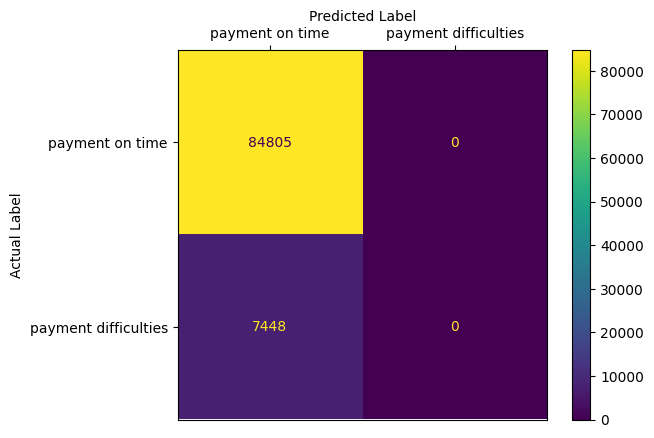

In [74]:
compute_confusion_matrix(y_test, y_pred_logreg, display_labels=target_labels)

In [75]:
display_classification_report(y_test, y_pred_logreg, display_labels=target_labels)

                      precision    recall  f1-score   support

     payment on time       0.92      1.00      0.96     84805
payment difficulties       0.00      0.00      0.00      7448

            accuracy                           0.92     92253
           macro avg       0.46      0.50      0.48     92253
        weighted avg       0.85      0.92      0.88     92253



In [76]:
classification_metrics(logRegModel, X_train_std, y_test, y_pred_logreg, list_metrics=list_metrics, roc_curve=False, beta=2)

Accuracy : 0.919
Recall : 0.0
AUC : 0.5
F1-score : 0.0
Fbeta-score (beta= 2 ) : 0.0


### c) KNN

In [77]:
# from sklearn import neighbors
# knnModel = neighbors.KNeighborsClassifier(algorithm='auto', n_neighbors=10)
# knnModel.fit(X_train_std, y_train)

In [78]:
# y_pred_knn = knnModel.predict(X_test_std)

In [79]:
# compute_confusion_matrix(y_test, y_pred_knn, display_labels=target_labels)

In [80]:
# display_classification_report(y_test, y_pred_knn, display_labels=target_labels)

In [81]:
# classification_metrics(knnModel, X_test_std, y_test, y_pred_knn, list_metrics=list_metrics, roc_curve=False, beta=2)

### d) RFC

In [82]:
from sklearn import ensemble
# {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200} Best Score - RFC: 0.9192732409427957
rfcModel = ensemble.RandomForestClassifier(criterion='gini', max_depth=4, max_features='auto', n_estimators=200)

In [83]:
rfcModel.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=4, max_features='auto', n_estimators=200)

In [84]:
features = [x for x in list(data.columns) if x != 'TARGET']
feature_importance_values = rfcModel.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

In [85]:
pd.options.display.float_format = "{:.3f}".format
top_ten_features = feature_importances.sort_values("importance", ascending=False)
top_ten_features.head(10)

,feature,importance
15,EXT_SOURCE_2,0.226
16,EXT_SOURCE_3,0.207
14,EXT_SOURCE_1,0.088
36,Y_BIRTH,0.050
58,NAME_EDUCATION_TYPE_Higher education,0.041
37,Y_EMPLOYED,0.036
56,NAME_INCOME_TYPE_Working,0.034
61,NAME_EDUCATION_TYPE_Secondary / secondary special,0.026
2,CODE_GENDER,0.025
9,REGION_RATING_CLIENT,0.023


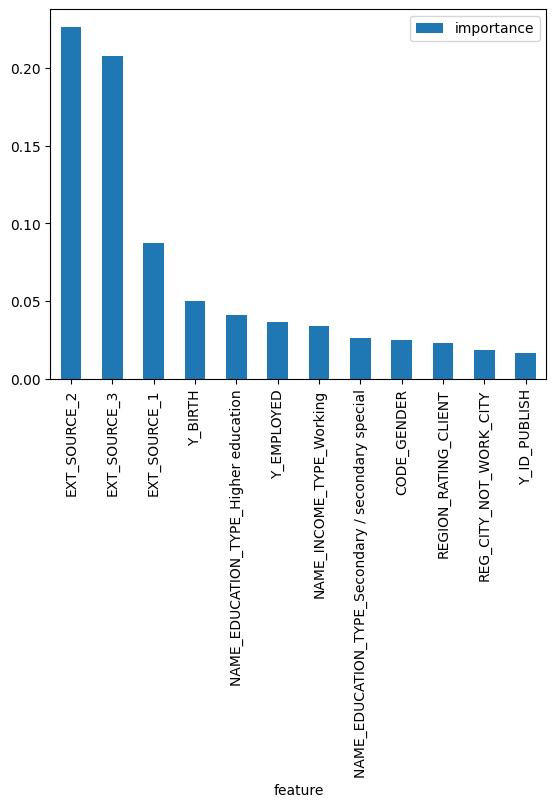

In [87]:
nb_features_zero = top_ten_features.loc[top_ten_features["importance"] >= 0.015, :]
nb_features_zero.plot(kind='bar', x="feature")
plt.show()

In [88]:
y_pred_rfc = rfcModel.predict(X_test_std)

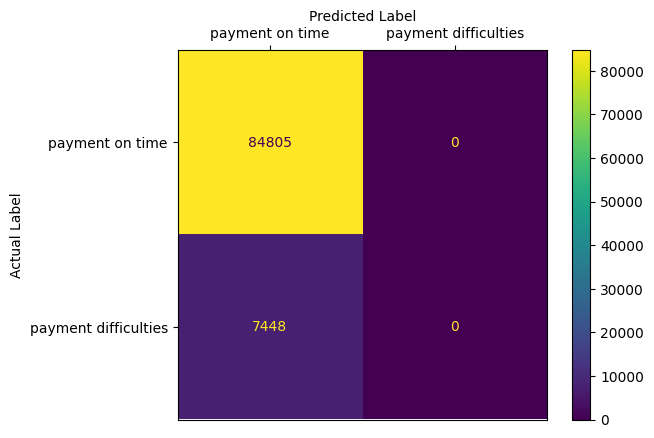

In [89]:
compute_confusion_matrix(y_test, y_pred_rfc, display_labels=target_labels)

In [90]:
display_classification_report(y_test, y_pred_rfc, display_labels=target_labels)

                      precision    recall  f1-score   support

     payment on time       0.92      1.00      0.96     84805
payment difficulties       0.00      0.00      0.00      7448

            accuracy                           0.92     92253
           macro avg       0.46      0.50      0.48     92253
        weighted avg       0.85      0.92      0.88     92253



In [91]:
classification_metrics(rfcModel, X_test_std, y_test, y_pred_rfc, list_metrics=list_metrics, roc_curve=False, beta=2)

Accuracy : 0.919
Recall : 0.0
AUC : 0.5
F1-score : 0.0
Fbeta-score (beta= 2 ) : 0.0


In [122]:
# from sklearn.model_selection import GridSearchCV
# rfcModel_grid = ensemble.RandomForestClassifier()
# parameters_rfc = {
#     'n_estimators': [200, 300, 400],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [3,4,5,6],
#     'criterion' :['gini', 'entropy']
# }
    
# # with GridSearch
# grid_search_rfc = GridSearchCV(
#     estimator=rfcModel_grid,
#     param_grid=parameters_rfc,
#     scoring = 'recall',
#     n_jobs = -1,
#     cv = 5
# )

In [123]:
# RFC_1=grid_search_rfc.fit(X_train_std, y_train)

In [124]:
# y_pred_RFC1 =RFC_1.predict(X_test_std)

In [125]:
# print(grid_search_rfc.best_params_ )
# print('Best Score - RFC:', grid_search_rfc.best_score_ )

{'class_weight': {0: 0.95, 1: 0.050000000000000044}}
Best Score - RFC: 0.004776531364091696


### e) XGBoost

In [96]:
xgBoostModel = ensemble.GradientBoostingClassifier()
xgBoostModel.fit(X_train_std, y_train)

GradientBoostingClassifier()

In [97]:
feature_importance_values_xgb = xgBoostModel.feature_importances_
feature_importances_xgb = pd.DataFrame({'feature': features, 'importance': feature_importance_values_xgb})

In [98]:
pd.options.display.float_format = "{:.3f}".format
top_ten_features_xgb = feature_importances_xgb.sort_values("importance", ascending=False)[:10]
top_ten_features_xgb

,feature,importance
15,EXT_SOURCE_2,0.334
16,EXT_SOURCE_3,0.326
14,EXT_SOURCE_1,0.100
36,Y_BIRTH,0.046
2,CODE_GENDER,0.025
6,AMT_CREDIT,0.022
58,NAME_EDUCATION_TYPE_Higher education,0.020
37,Y_EMPLOYED,0.020
7,AMT_ANNUITY,0.015
56,NAME_INCOME_TYPE_Working,0.011


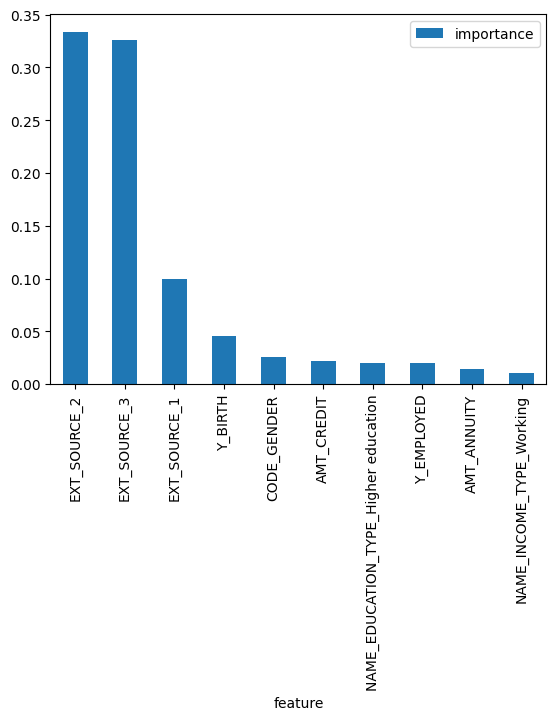

In [99]:
top_ten_features_xgb.plot(kind='bar', x="feature")
plt.show()

In [100]:
y_pred_xgb = xgBoostModel.predict(X_test_std)

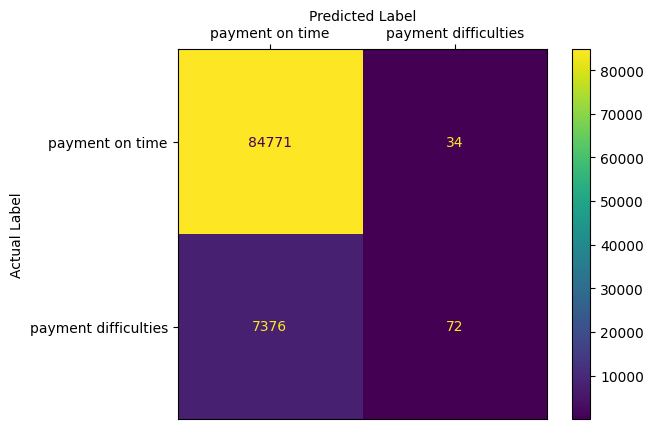

In [101]:
compute_confusion_matrix(y_test, y_pred_xgb, display_labels=target_labels)

In [102]:
display_classification_report(y_test, y_pred_xgb, display_labels=target_labels)

                      precision    recall  f1-score   support

     payment on time       0.92      1.00      0.96     84805
payment difficulties       0.68      0.01      0.02      7448

            accuracy                           0.92     92253
           macro avg       0.80      0.50      0.49     92253
        weighted avg       0.90      0.92      0.88     92253



In [103]:
classification_metrics(xgBoostModel, X_test_std, y_test, y_pred_xgb, list_metrics=list_metrics, roc_curve=False, beta=0.5)

Accuracy : 0.92
Recall : 0.01
AUC : 0.505
F1-score : 0.019
Fbeta-score (beta= 0.5 ) : 0.046


### RFC class_weight

In [104]:
# {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200} Best Score - RFC: 0.9192732409427957
rfcModel_bal = ensemble.RandomForestClassifier(criterion='gini', max_depth=4, max_features='auto', n_estimators=200, class_weight="balanced")

In [105]:
rfcModel_bal.fit(X_train_std, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4,
                       max_features='auto', n_estimators=200)

In [106]:
feature_importance_values_bal = rfcModel_bal.feature_importances_
feature_importances_bal = pd.DataFrame({'feature': features, 'importance': feature_importance_values_bal})

In [107]:
pd.options.display.float_format = "{:.3f}".format
top_ten_features_bal = feature_importances_bal.sort_values("importance", ascending=False)[:10]
top_ten_features_bal

,feature,importance
15,EXT_SOURCE_2,0.220
16,EXT_SOURCE_3,0.202
14,EXT_SOURCE_1,0.098
36,Y_BIRTH,0.054
37,Y_EMPLOYED,0.050
58,NAME_EDUCATION_TYPE_Higher education,0.044
56,NAME_INCOME_TYPE_Working,0.028
40,FLAG_UNEMPLOYED,0.026
2,CODE_GENDER,0.024
150,ORGANIZATION_TYPE_XNA,0.022


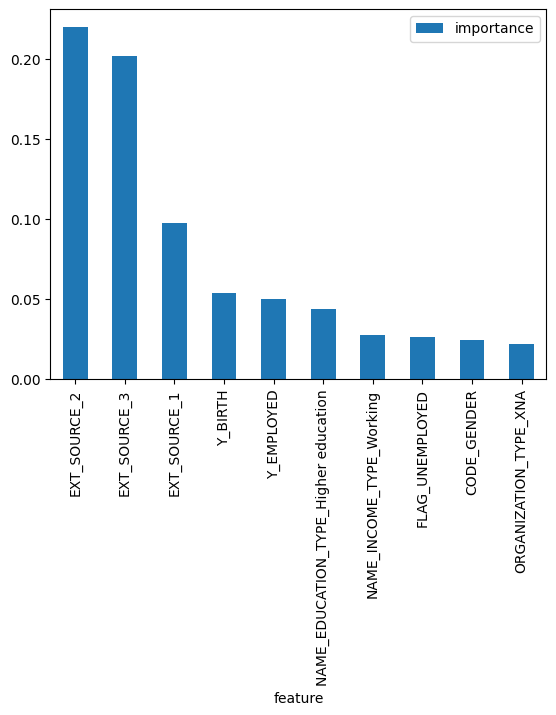

In [108]:
top_ten_features_bal.plot(kind='bar', x="feature")
plt.show()

In [109]:
y_pred_rfc_bal = rfcModel_bal.predict(X_test_std)

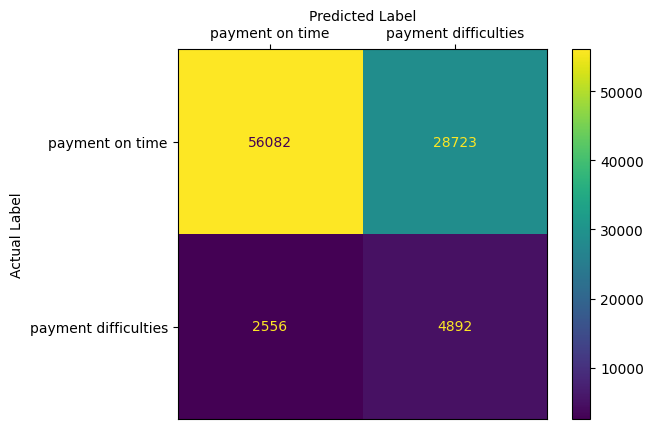

In [110]:
compute_confusion_matrix(y_test, y_pred_rfc_bal, display_labels=target_labels)

In [111]:
display_classification_report(y_test, y_pred_rfc_bal, display_labels=target_labels)

                      precision    recall  f1-score   support

     payment on time       0.96      0.66      0.78     84805
payment difficulties       0.15      0.66      0.24      7448

            accuracy                           0.66     92253
           macro avg       0.55      0.66      0.51     92253
        weighted avg       0.89      0.66      0.74     92253



Accuracy : 0.661
Recall : 0.657
AUC : 0.659
F1-score : 0.238
Fbeta-score (beta= 2 ) : 0.386


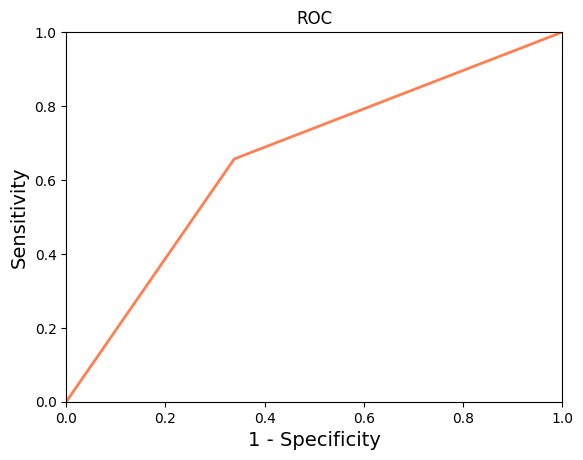

In [112]:
classification_metrics(rfcModel_bal, X_test_std, y_test, y_pred_rfc_bal, list_metrics=list_metrics, roc_curve=True, beta=2)

### RFC SMOTE_NC

In [113]:
# {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 200} Best Score - RFC: 0.9192732409427957
rfcModel_smote = ensemble.RandomForestClassifier(criterion='gini', max_depth=4, max_features='auto', n_estimators=200)

In [114]:
rfcModel_smote.fit(X_smote, y_smote)

RandomForestClassifier(max_depth=4, max_features='auto', n_estimators=200)

In [115]:
feature_importance_values_smote = rfcModel_smote.feature_importances_
feature_importances_smote = pd.DataFrame({'feature': features, 'importance': feature_importance_values_smote})

In [116]:
pd.options.display.float_format = "{:.3f}".format
top_ten_features_smote = feature_importances_smote.sort_values("importance", ascending=False)[:10]
top_ten_features_smote

,feature,importance
16,EXT_SOURCE_3,0.143
15,EXT_SOURCE_2,0.108
35,AMT_REQ_CREDIT_BUREAU_YEAR,0.096
28,OBS_30_CNT_SOCIAL_CIRCLE,0.090
4,CNT_CHILDREN,0.068
14,EXT_SOURCE_1,0.063
29,DEF_30_CNT_SOCIAL_CIRCLE,0.063
9,REGION_RATING_CLIENT,0.049
8,REGION_POPULATION_RELATIVE,0.033
33,AMT_REQ_CREDIT_BUREAU_MON,0.030


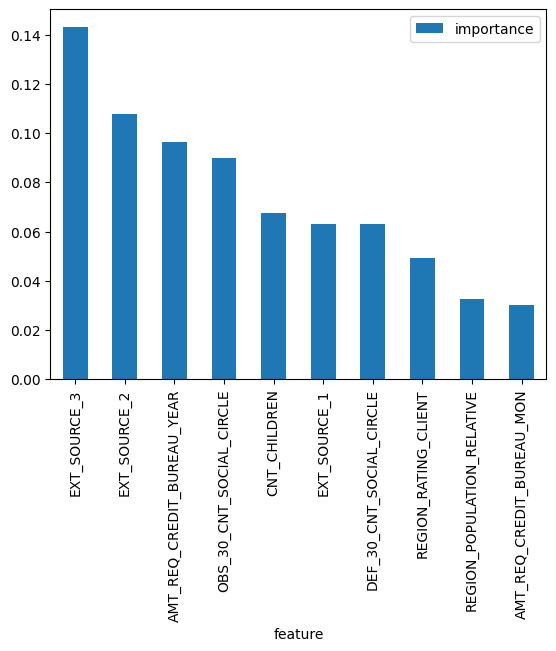

In [117]:
top_ten_features_smote.plot(kind='bar', x="feature")
plt.show()

In [118]:
y_pred_rfc_smote = rfcModel_smote.predict(X_test_std)

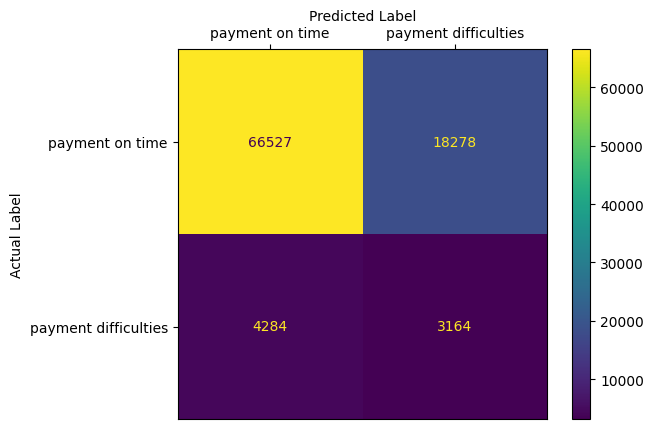

In [119]:
compute_confusion_matrix(y_test, y_pred_rfc_smote, display_labels=target_labels)

In [120]:
display_classification_report(y_test, y_pred_rfc_smote, display_labels=target_labels)

                      precision    recall  f1-score   support

     payment on time       0.94      0.78      0.86     84805
payment difficulties       0.15      0.42      0.22      7448

            accuracy                           0.76     92253
           macro avg       0.54      0.60      0.54     92253
        weighted avg       0.88      0.76      0.80     92253



Accuracy : 0.755
Recall : 0.425
AUC : 0.605
F1-score : 0.219
Fbeta-score (beta= 2 ) : 0.309


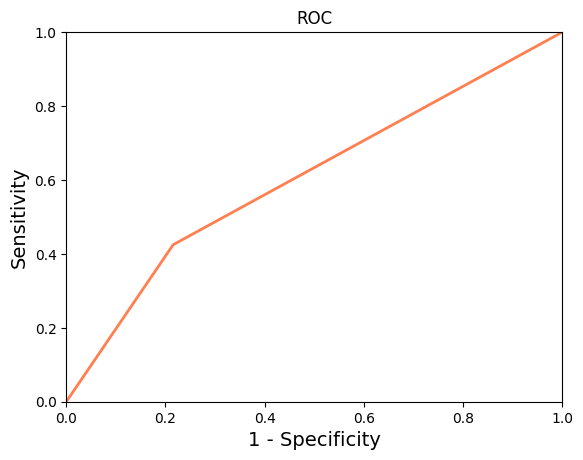

In [121]:
classification_metrics(rfcModel_smote, X_test_std, y_test, y_pred_rfc_smote, list_metrics=list_metrics, roc_curve=True, beta=2)

### LightGBM

In [126]:
from lightgbm import LGBMClassifier
LGBMModel = LGBMClassifier()

In [127]:
LGBMModel.fit(X_train_std, y_train)

LGBMClassifier()

In [128]:
feature_importance_values_lgbm = LGBMModel.feature_importances_
feature_importances_lgbm = pd.DataFrame({'feature': features, 'importance': feature_importance_values_lgbm})

In [129]:
pd.options.display.float_format = "{:.3f}".format
top_ten_features_lgbm = feature_importances_lgbm.sort_values("importance", ascending=False)[:10]
top_ten_features_lgbm

,feature,importance
14,EXT_SOURCE_1,259
16,EXT_SOURCE_3,244
6,AMT_CREDIT,225
15,EXT_SOURCE_2,197
36,Y_BIRTH,192
7,AMT_ANNUITY,155
37,Y_EMPLOYED,154
39,Y_ID_PUBLISH,139
38,Y_REGISTRATION,101
5,AMT_INCOME_TOTAL,93


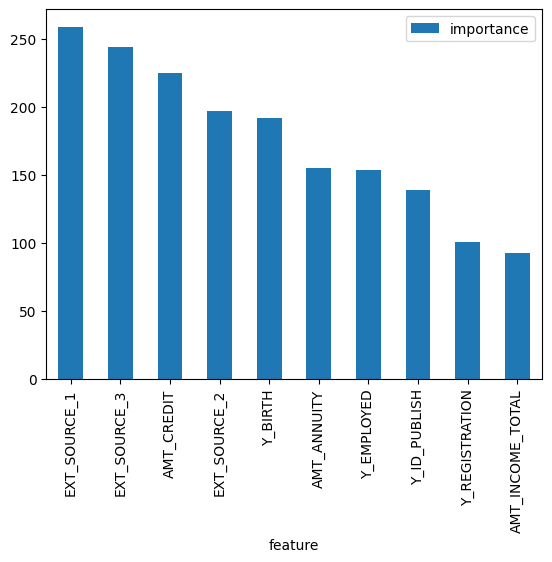

In [130]:
top_ten_features_lgbm.plot(kind='bar', x="feature")
plt.show()

In [131]:
y_pred_lgbm = LGBMModel.predict(X_test_std)

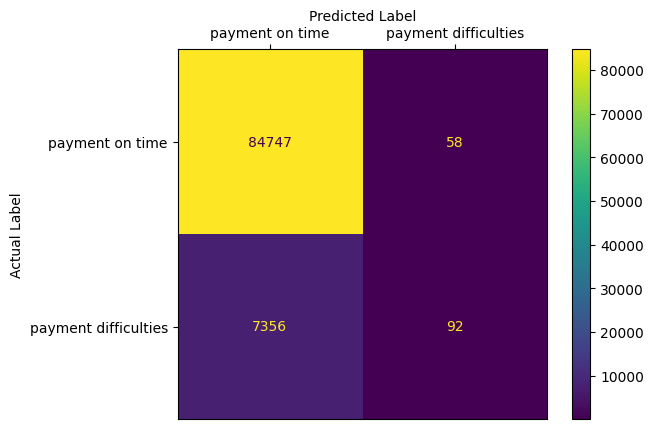

In [132]:
compute_confusion_matrix(y_test, y_pred_lgbm, display_labels=target_labels)

In [133]:
display_classification_report(y_test, y_pred_lgbm, display_labels=target_labels)

                      precision    recall  f1-score   support

     payment on time       0.92      1.00      0.96     84805
payment difficulties       0.61      0.01      0.02      7448

            accuracy                           0.92     92253
           macro avg       0.77      0.51      0.49     92253
        weighted avg       0.90      0.92      0.88     92253



Accuracy : 0.92
Recall : 0.012
AUC : 0.506
F1-score : 0.024
Fbeta-score (beta= 2 ) : 0.015


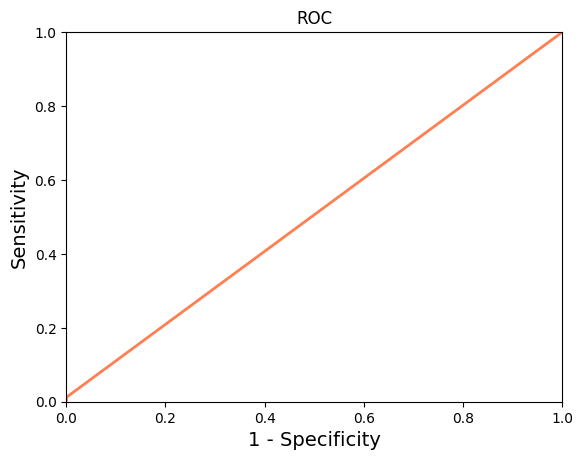

In [134]:
classification_metrics(LGBMModel, X_test_std, y_test, y_pred_lgbm, list_metrics=list_metrics, roc_curve=True, beta=2)